# SDTSIA 211 : TP Recommender systems

Mona Mokart

## Fonctions and importations


In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

**========================================================================================================================**
### Question 1.1

In [2]:
R1,mask1 = load_movielens("ml-100k/u.data")

In [3]:
R1.shape

(943, 1682)

Test for minidata= True

In [4]:
R2,mask2 = load_movielens("ml-100k/u.data",True)

In [5]:
R2.shape

(100, 200)

We notice that minidata crosses the R matrices and the mask in size (100,200), we study on the 100 first users and 200 first films.

**========================================================================================================================**

### Question 1.2

In [7]:
countmatrice = mask1.astype('float64')
np.sum(countmatrice)

100000.0

There are 943 usuers and 1682 films and 100000 grades

**========================================================================================================================**

### Question 2.1

$ g(P) = \frac{1}{2}||1_K\circ (R-Q^0P)||^2_F + \frac{\rho}{2} ||Q^0||^2_F +\frac{\rho}{2}||P||^2_F$

$= \frac{1}{2} \sum_u\sum_i 1_{K(u,i)}(R_{ui}-\sum_f Q^0_{uf}P_{fi})^2 + \frac{\rho}{2} ||Q^0||^2_F + \frac{\rho}{2} \sum_i \sum_u P_{ui}^2$

Gradient : 
$\frac{\partial g}{\partial P_{kl}} = \sum_u \sum_i 1_{K(u,i)}\delta_{il}(R_{ui}-\sum_f Q^0_{uf}P_{fi})(-Q_{uk}^0) + \rho P{kl}$


$\frac{\partial g}{\partial P_{kl}} = \sum_u 1_{K(u,l)}(R_{ul}-\sum_f Q^0_{uf}P_{fl})(-Q_{uk}^0) + \rho P{kl}$

$\implies \nabla g(P) = - (Q^0)^T(1_K\circ(R- Q^0P)) +\rho P$

**========================================================================================================================**

### Question 2.2

In [4]:

def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    grad_P =  (-(Q0.T).dot(tmp) +rho*P)
    return val.copy(), grad_P.copy()

In [7]:
from scipy.sparse import linalg
u,s,vt=linalg.svds(R1,k=4)

In [8]:
Q0 = u
P0 = vt
rho=0.3
g,grad = objective(P0, Q0, R1, mask1, rho)
print(grad)

[[ 2.55511347e+00  5.13441086e-01  7.73878335e+00 ... -1.51419184e-01
   1.22846636e-02  2.77930288e-01]
 [-3.66873174e+00 -1.35718942e+01 -2.52859733e+00 ...  1.15949951e-01
  -9.88378905e-02 -5.68629500e-02]
 [ 2.12714964e+01  1.71114543e+00  6.98904993e+00 ...  1.09578207e-01
  -2.57325476e-02 -4.96748331e-02]
 [ 6.13606989e+01  2.24992343e+01  1.27481888e+01 ...  1.94487024e-02
   2.11983433e-01  2.02878594e-01]]


In [9]:
#Check of the gradient 
from scipy.optimize import check_grad
C=P0.shape[0]
I=P0.shape[1]


def func(P):
    P2=np.reshape(P,(C,I))
    g,grad=objective(P2, Q0, R1, mask1, 0.3)
    return g


def grad_func (P):
    P2=np.reshape(P,(C,I))
    g,grad=objective(P2, Q0, R1, mask1, 0.3)
    return np.ravel(grad)

In [11]:
error = check_grad(func, grad_func, np.ravel(P0))
print("Error :",error)
print("Normalized error :", error/(np.sum(grad_func(P0) ** 2)**0.5))

Error : 1.1700266977214362
Normalized error : 0.0015909589213310487


**========================================================================================================================**

### Question 2.3

In [12]:
def gradient(g, P0, gamma, epsilon):
    """g is a function which return two vectors, the first is g(P,Q0) and the second is  the gradient of g(P,Q0)"""
    pk=P0.copy()
    k=0
    d=np.sum(g(pk)[1] ** 2)**0.5 # ||grad_g(P,Q0)||
    while d >epsilon:
        pk= pk - gamma*g(pk)[1]
        k+=1
        d = np.sum(g(pk)[1] ** 2)**0.5
    return pk, g(pk)[0],k

**========================================================================================================================**

### Question 2.4

In [14]:
rho=0.3
L0 = rho + np.sum(np.dot(Q0.T, Q0) ** 2)**0.5
gamma = 1/L0
epsilon=1
p_star, min_g, iterations = gradient(lambda P : objective(P, Q0, R1, mask1, rho), P0, gamma, epsilon)
relative_error = np.linalg.norm(R1 - Q0@p_star)/np.linalg.norm(R1)

In [19]:
print("The result for the value of the min of g(P,Q0) is : ", min_g)
print("\n\nMinimizer P : ",p_star)
print("\n\nRelative error :",relative_error)

The result for the value of the min of g(P,Q0) is :  369551.54991481925


Minimizer P :  [[ 2.23284225e+00 -4.90664665e-01 -9.98919015e+00 ...  4.74987005e-01
  -3.92212474e-02 -8.67808467e-01]
 [-4.53777371e+00  1.35365298e+01  2.56785789e+00 ... -3.63533351e-01
   3.15394841e-01  1.77455812e-01]
 [-2.02978127e+01 -4.68180885e-01 -1.07452929e+01 ... -3.43502581e-01
   8.21005494e-02  1.54999171e-01]
 [-5.76416726e+01 -2.77454348e+01 -1.98640643e+01 ... -6.09197523e-02
  -6.75813808e-01 -6.32544121e-01]]


Relative error : 0.8121916798396361


We have a relative error of 81% which is a lot, maybe with $\rho$ lower we would have been closer to R

**========================================================================================================================**

### Question 2.5

In [18]:
def find_new_gammaP(g,P,a,b): 
    """find the gamma = ba**l such as :  g(P+,Q0)< g(Pk,Q0)-0.5ba**l||grad_g(Pk,QO)||²"""
    gamma=b
    while g(P - gamma*g(P)[1])[0]> g(P)[0]  - gamma*np.sum(g(P)[1] ** 2)/2:
        gamma=gamma*a
    return gamma

def gradient_searchlineP(g, P0,epsilon,a,b):
    pk=P0.copy()
    k=0
    d=np.sum(g(pk)[1] ** 2)**0.5
    gamma=b/2
    while d >epsilon:
        b=2*gamma
        gamma = find_new_gammaP(g,pk,a,b)
        pk= pk - gamma*g(pk)[1]
        k+=1
        d = np.sum(g(pk)[1] ** 2)**0.5
    return pk, g(pk)[0],k

In [19]:
rho=0.3
epsilon=1
a=0.5
b=1
p_star2, min_g2, iterations2 = gradient_searchlineP(lambda P : objective(P, Q0, R1, mask1, rho), P0, epsilon,a,b)
relative_error2 = np.linalg.norm(R1 - Q0@p_star2)/np.linalg.norm(R1)

In [20]:
print("The result for the value of the min of g(P,Q0) is : ", min_g2)
print("\n\n Minimizer P : ",p_star2)
print("\n\nRelative error :",relative_error2)

The result for the value of the min of g(P,Q0) is :  369551.06050388445


 Minimizer P :  [[ 2.22795129e+00 -4.88567957e-01 -9.97192431e+00 ...  4.75383866e-01
  -3.92298322e-02 -8.68665181e-01]
 [-4.53125514e+00  1.35259301e+01  2.55585707e+00 ... -3.63837001e-01
   3.15463796e-01  1.77630956e-01]
 [-2.02965476e+01 -4.62917756e-01 -1.07466274e+01 ... -3.43789475e-01
   8.21184930e-02  1.55152139e-01]
 [-5.76442343e+01 -2.77539771e+01 -1.98693242e+01 ... -6.09706102e-02
  -6.75961260e-01 -6.33168148e-01]]


Relative error : 0.8123468997661466


We find a result which is almost the same than without line search

### Question 3.1 

We remarke that f is a polynomial of degree 4 :$ f(P,Q)  = \frac{1}{2}||1_K\circ (R-QP)||^2_F + \frac{\rho}{2} ||Q||^2_F +\frac{\rho}{2}||P||^2_F$ (double scalar product of the product of vectors P and Q)

Then its gradient is a polynomial of degree 3 and its hessian matrix is polynomial of degree 2.

A function is Lipschitz continous $\iff$ it has bounded first derivative. 

Then here, $\nabla f$ is not Lipschizt continuous since its first derivative, a polynomial function of degree 2 is not bounded 




**========================================================================================================================**

### Question 3.2
First we need to complete the function *total_objective* because we must take into account the gradient of g with respect to Q :

$\nabla g_2 (Q) = -(1_K\circ((R-QP_0))P_0^T) + \rho Q$

In [26]:
def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = (-(Q.T).dot(tmp) +rho*P)

    grad_Q = (-tmp.dot(P.T) +rho*Q)

    return val, grad_P, grad_Q


def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0] // (n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])


Then we compute the gradient descent 

In [22]:
def find_new_gammaPQ(g,PQvec,a,b):
    gamma=b
    while g(PQvec - gamma*g(PQvec)[1])[0]> g(PQvec)[0]  - gamma*np.sum(g(PQvec)[1] ** 2)/2:
        gamma=gamma*a
    return gamma

def gradient_searchlinePQ(g, PQvec0 ,epsilon,a,b):
    PQvec=PQvec0.copy()
    k=0
    d=np.sum(g(PQvec)[1] ** 2)**0.5
    gamma=b/2
    while d >epsilon:
        b=2*gamma
        gamma = find_new_gammaPQ(g,PQvec,a,b)
        PQvec= PQvec - gamma*g(PQvec)[1]
        k+=1
        d = np.sum(g(PQvec)[1] ** 2)**0.5
    return PQvec, g(PQvec)[0],k

In [23]:
rho=0.3
epsilon=100
a=0.5
b=1
Pvec0 = np.ravel(P0)
Qvec0=np.ravel(Q0)
PQvec0= np.concatenate([Pvec0,Qvec0])
PQ_star, min_gPQ, iterationsPQ = gradient_searchlinePQ(lambda PQvec :total_objective_vectorized(PQvec, R1, mask1, rho) , PQvec0, epsilon,a,b)

print("The result for the value of the min of g(P,Q) is : ", min_gPQ)

The result for the value of the min of g(P,Q) is :  36092.80541112954


It is a logical result since we obtain a value of g which is smaller than the output value of the gradient descent with P only and Q0 as a constant.



In [25]:
n_items = R1.shape[1]
n_users = R1.shape[0]
F = PQ_star.shape[0] // (n_items + n_users)
P_starvec = PQ_star[0:n_items*F]
Q_starvec = PQ_star[n_items*F:]

P_star = np.reshape(P_starvec, (F, n_items))
Q_star= np.reshape(Q_starvec, (n_users, F))
R_star = Q_star.dot(P_star)

relative_error3 = np.linalg.norm(R_star-R1)/np.linalg.norm(R1)
print("Relative error :",relative_error3 )

Relative error : 2.7919723459336208


We find a relative error of 279%, so even if we reached a value of g(P,Q) lower than with Q0 fixed, we have a value of $\hat{R}$ less close to R


**Interpretation :**

This algorithm minimizes this function: $\frac{1}{2}||1_K\circ (R-QP)||^2_F + \frac{\rho}{2} ||Q||^2_F +\frac{\rho}{2}||P||^2_F$ i.e. finds P and Q (with a regularization parameter) such that PQ is $\approx$ R for the values of R which are non-zero. We thus obtain a result $\hat{R}$ which is $\approx$ R for the non-zero values of R and other values which correspond to a prediction of the grades for the movies that the users have not watched. 

P and Q are matrices of respective sizes (U,C) and (C,I). U = number of users, I = number of items (film) and C corresponds to a number of criteria. Each film would have a certain value for criteria 0, 1, 2 or 3. Each user too.

**========================================================================================================================**

### Question 3.3

To find the film to be recommended for user 300 we have to calculate $\hat{R}$ and look at the values $\hat{R}_{i,j}$ such that $R_{i,j} = 0$, i.e. the predicted ratings for films not watched. Then we are interested in line 300 and we choose the argmax of this vector (= the id number of the film which has the best note in prediction for the user 300).


In [46]:
r_mask=1-mask1 #r_mask for "recommendation mask"
r_R = R_star*r_mask #Recommendation matrix
User_300 = r_R[300]
recommanded_film = np.argmax(User_300)
best_grade_film=np.argwhere(R1[300]==5)

In [83]:
print("I recommend the film number",recommanded_film,"for user 300") 
print("The",len(best_grade_film)," highest rated films (5/5) by user 300 are :")
for val in best_grade_film:
    print(val[0])

I recommend the film number 312 for user 300
The 32  highest rated films (5/5) by user 300 are :
42
49
63
68
78
81
94
95
99
108
116
127
171
173
180
181
194
196
201
203
214
225
268
317
356
383
454
495
587
650
692
1027


Let's take a look at what film 312 and films 42,49,63 and 68 look like. They should look alike

**Recommended film :**

Text(0.5, 1.0, 'Predicted grades for user 300')

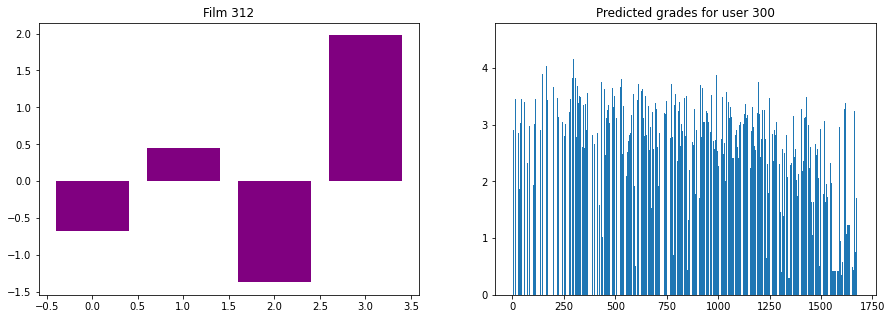

In [79]:

X=range(1682)

fig  = plt.figure(3, figsize=(15, 5))
axis=fig.add_subplot(1, 2, 1)
axis.bar(range(4),P_star[:,recommanded_film],color='purple')
axis.set_title("Film 312")
axis=fig.add_subplot(1, 2, 2)
axis.bar(X,User_300)
axis.set_title("Predicted grades for user 300")

**Highest rated films by user 300 :**

Text(0.5, 1.0, 'Film 68')

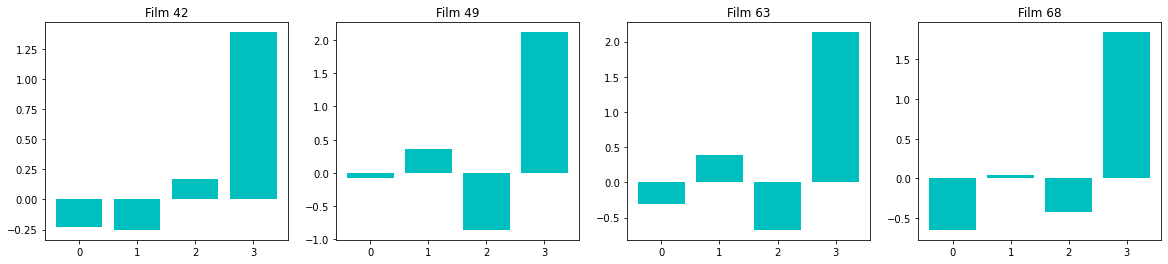

In [75]:
fig  = plt.figure(4, figsize=(20, 4))
axis=fig.add_subplot(1, 4, 1)
axis.bar(range(4),P_star[:,42],color='c')
axis.set_title("Film 42")
axis=fig.add_subplot(1, 4, 2)
axis.bar(range(4),P_star[:,49],color='c')
axis.set_title("Film 49")
axis=fig.add_subplot(1, 4, 3)
axis.bar(range(4),P_star[:,63],color='c')
axis.set_title("Film 63")
axis=fig.add_subplot(1, 4, 4)
axis.bar(range(4),P_star[:,68],color='c')
axis.set_title("Film 68")

We notice that user 300 chooses films with high criterion 3 (close to 2), this can be a clue to predict the films that he likes. We can see that the recommended film is worth about 2 for criterion 3, so the reasoning is logical. Moreover, in general we can see that the values of the criteria for film 312 look like those of the top rated films.







**Lowest rated films (grade 1/5):**

In [49]:
worst_grade_film=np.argwhere(R1[300]==1)
print(worst_grade_film)

[[  52]
 [ 110]
 [ 154]
 [ 272]
 [ 275]
 [ 394]
 [ 410]
 [ 422]
 [ 630]
 [ 654]
 [1051]
 [1229]]


Text(0.5, 1.0, 'Film 272')

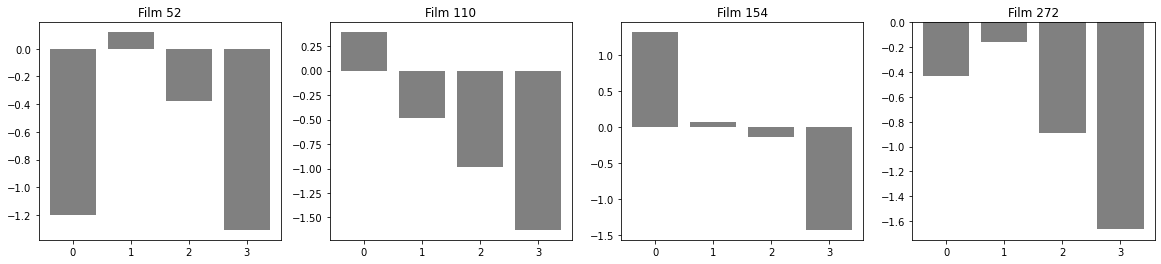

In [47]:
fig  = plt.figure(4, figsize=(20, 4))
axis=fig.add_subplot(1, 4, 1)
axis.bar(range(4),P_star[:,52],color='gray')
axis.set_title("Film 52")
axis=fig.add_subplot(1, 4, 2)
axis.bar(range(4),P_star[:,110],color='gray')
axis.set_title("Film 110")
axis=fig.add_subplot(1, 4, 3)
axis.bar(range(4),P_star[:,154],color='gray')
axis.set_title("Film 154")
axis=fig.add_subplot(1, 4, 4)
axis.bar(range(4),P_star[:,272],color='gray')
axis.set_title("Film 272")

They look very different from the recommended film 312